In [1]:
import os

import numpy as np
import cv2   as cv

import matplotlib.pyplot as plt
import numpy.linalg      as la

from matplotlib.pyplot   import imshow, subplot, title, plot

from ipywidgets          import interactive

%matplotlib inline

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread(file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def imshowg(x):
    imshow(x, "gray")

# para imprimir arrays con el número de decimales deseados
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)

def sharr(a, prec=3):
    with printoptions(precision=prec, suppress=True):
        print(a)
        
        
### HERRAMIENTAS

# crea un vector (array 1D)
def vec(*argn):
    return np.array(argn)

# convierte un conjunto de puntos ordinarios (almacenados como filas de la matriz de entrada)
# en coordenas homogéneas (añadimos una columna de 1)
def homog(x):
    ax = np.array(x)
    uc = np.ones(ax.shape[:-1]+(1,))
    return np.append(ax,uc,axis=-1)

# convierte en coordenadas tradicionales
def inhomog(x):
    ax = np.array(x)
    return ax[..., :-1] / ax[...,[-1]]


# aplica una transformación homogénea h a un conjunto
# de puntos ordinarios, almacenados como filas 
def htrans(h,x):
    return inhomog(homog(x) @ h.T)

def desp(d):
    dx,dy = d
    return np.array([
            [1,0,dx],
            [0,1,dy],
            [0,0,1]])

def scale(s):
    sx,sy = s
    return np.array([
            [sx,0,0],
            [0,sy,0],
            [0,0,1]])

# rotación eje "vertical" del plano
def rot3(a):
    c = np.cos(a)
    s = np.sin(a)
    return np.array([
            [c,-s,0],
            [s, c,0],
            [0, 0,1]])

pi = np.pi
degree = pi/180

In [2]:
rutas_list = [
    '../tickets_imagenes/181010_carreforur_conflash_1.JPG',
    '../tickets_imagenes/181010_carreforur_conflash_2.JPG',
    '../tickets_imagenes/181010_carreforur_conflash_3.JPG', 
]

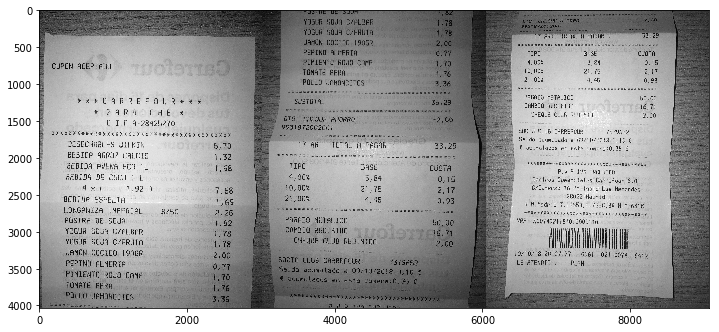

In [4]:
rgb_list = []
images_list = []
for index, item in enumerate(rutas_list):
    rgb_list.append(readrgb(item))
    images_list.append(rgb2gray(rgb_list[index]))
#rgb1 = readrgb('../tickets_imagenes/181010_carreforur_conflash_1.JPG')
#rgb2 = readrgb('../tickets_imagenes/181010_carreforur_conflash_2.JPG')
#rgb3 = readrgb('../tickets_imagenes/181010_carreforur_conflash_3.JPG')
#x1 = rgb2gray(rgb1)
#x2 = rgb2gray(rgb2)
#x3 = rgb2gray(rgb3)

fig(12,12)
imshowg(np.hstack(images_list));

In [6]:
# Creamos un objeto SIFT. @see https://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html
sift = cv.xfeatures2d.SIFT_create(contrastThreshold=0.1, edgeThreshold=10)
# "Detectamos y computamos" los puntos clave de la imagen. https://docs.opencv.org/3.1.0/d1/de0/tutorial_py_feature_homography.html
kps_descs_list = []
for index, item in enumerate(images_list):
    kps_descs_list.append(sift.detectAndCompute(item, None))
    print("#", index, "kps:", len(kps_descs_list[index][0]), ", descriptors1:", kps_descs_list[index][1].shape)
#(kps1, descs1) = sift.detectAndCompute(x1, None)
#print("# kps1: {}, descriptors1: {}".format(len(kps1), descs1.shape))

#imshow( cv.drawKeypoints(image=x1,
#                         keypoints=kps1,
#                         outImage=None,
#                         flags=4, color = (128,0,0)) );

# 0 kps: 23630 , descriptors1: (23630, 128)
# 1 kps: 16961 , descriptors1: (16961, 128)
# 2 kps: 24955 , descriptors1: (24955, 128)


# kps2: 16961, descriptors2: (16961, 128)


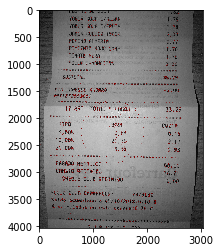

In [5]:
# Repetimos la operacion para la imagen 2
(kps2, descs2) = sift.detectAndCompute(x2, None)
print("# kps2: {}, descriptors2: {}".format(len(kps2), descs2.shape))

imshow( cv.drawKeypoints(image=x2,
                         keypoints=kps2,
                         outImage=None,
                         flags=4, color = (128,0,0)) );

In [6]:
#Temporal1

TypeError: len() takes exactly one argument (0 given)

In [10]:
# Creamos el objeto BFMatcher para encajar los descriptores hallados en el paso anterior
# ver https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html
bf = cv.BFMatcher()
max_val = (x1, kps1, descs1) if len(kps1) > len(kps2) else (x2, kps2, descs2)
min_val = (x1, kps1, descs1) if len(kps1) < len(kps2) else (x2, kps2, descs2)
# Dibujamos los matches entre las imágenes 1 y 2. KNN -> K and nearest neighbours with k groups.
matches12 = bf.knnMatch(min_val[2],max_val[2],k=2)
# Dibujamos los matches entre las imágenes 2 y 3
#max_val = (x2, kps2, descs2) if len(kps2) > len(kps3) else (x3, kps3, descs3)
#min_val = (x2, kps2, descs2) if len(kps2) < len(kps3) else (x3, kps3, descs3)

#matches23 = bf.knnMatch(min_val[2],max_val[2],k=2)

#print(len(matches12))


1297
<DMatch 0x109b5c3f0> <DMatch 0x109b5c410>
6287 16960
23630 16961


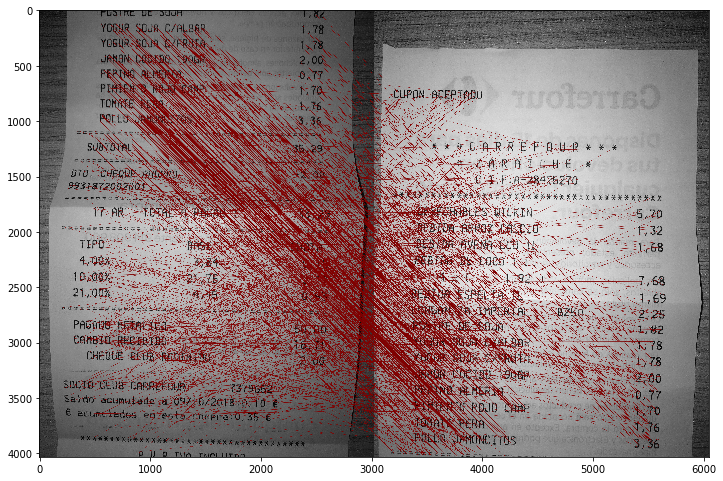

In [12]:
# para quedarnos solo los que tienen muy poca ambigüedad.

# Apply ratio test (1 & 2)
good12 = []
for m12,n12 in matches12:
    if m12.distance < 0.75*n12.distance:   
        good12.append(m12)

print(len(good12))
  
# drawMatches usa la estructura matches1to2
img12 = cv.drawMatches(min_val[0],min_val[1],
                       max_val[0],max_val[1],
                       good12,
                       flags=2,outImg=None,
                       matchColor=(128,0,0))

fig(12,12)
plt.imshow(img12)
print(m12, n12)
print(m12.trainIdx, m12.queryIdx)
print(len(kps1), len(kps2))


# Apply ratio test (2 & 3)
#good23 = []
#for m,n in matches23:
#    if m.distance < 0.75*n.distance:
#        good23.append(m)

#print(len(good23))
        
# drawMatches usa la estructura matches2to3
#img23 = cv.drawMatches(x2,kps2,
#                      x3,kps3,
#                      good23,
#                      flags=2,outImg=None,
#                      matchColor=(128,0,0))

#fig(12,12)
#plt.imshow(img23);

In [1]:
#Temporal2
kps1

NameError: name 'kps1' is not defined

In [13]:
# a partir de los matchings seleccionados construimos los arrays de puntos que necesita findHomography
# ¡CUIDADO! Aquí 'm' sigue valiendo lo que valiera al salir del bucle anterior.
src_pts1 = np.array([ kps1[m12.trainIdx].pt for m12 in good12 ]).astype(np.float32).reshape(-1,2)
dst_pts2 = np.array([ kps2[m12.queryIdx].pt for m12 in good12 ]).astype(np.float32).reshape(-1,2)

#PRUEBA
#np.array([ kps1[m.trainIdx].pt for m1 in good12 ]).astype(np.float32).reshape(-1,2)
#FIN_PRUEBA

#src_pts2 = np.array([ kps2[m2.trainIdx].pt for m2 in good23 ]).astype(np.float32).reshape(-1,2)
#dst_pts3 = np.array([ kps3[m2.queryIdx].pt for m2 in good23 ]).astype(np.float32).reshape(-1,2)

In [14]:
H, mask = cv.findHomography(src_pts1, dst_pts2, cv.RANSAC, 3) # cv.LMEDS
sharr(H)

[[    0.881    -0.023   298.421]
 [   -0.013     0.897 -2511.486]
 [    0.       -0.        1.   ]]


In [15]:
# mask viene como una array 2D de 0 ó 1, lo convertimos a un array 1D de bool
matchesMask = mask.ravel()>0

ok = [ good12[k] for k in range(len(good12)) if matchesMask[k] ]

# good es una lista, si fuera un array prodríamos hacer directamente
# ok = good[matchesMask]

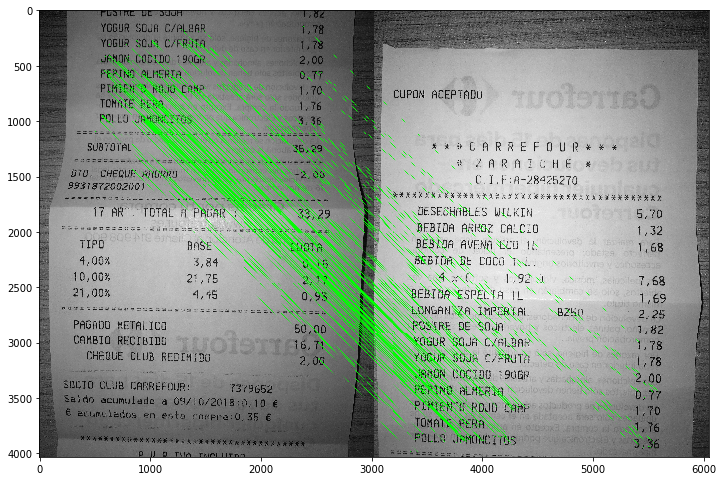

In [16]:
img4 = cv.drawMatches(min_val[0],min_val[1],
                       max_val[0],max_val[1],ok,flags=2,outImg=None,matchColor=(0,255,0))

fig(12,12)
plt.imshow(img4);

In [17]:
def t(h,x):
    return cv.warpPerspective(x, desp((200,200)) @ h,(3500,10000))

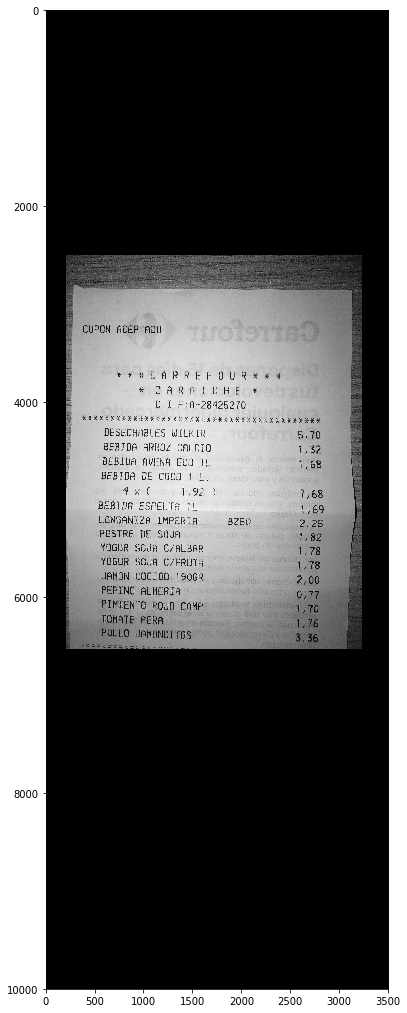

In [18]:
#Mostramos las imágenes en una más grande.
#fig(18,18)

#imshowg(t(np.eye(3),x1))

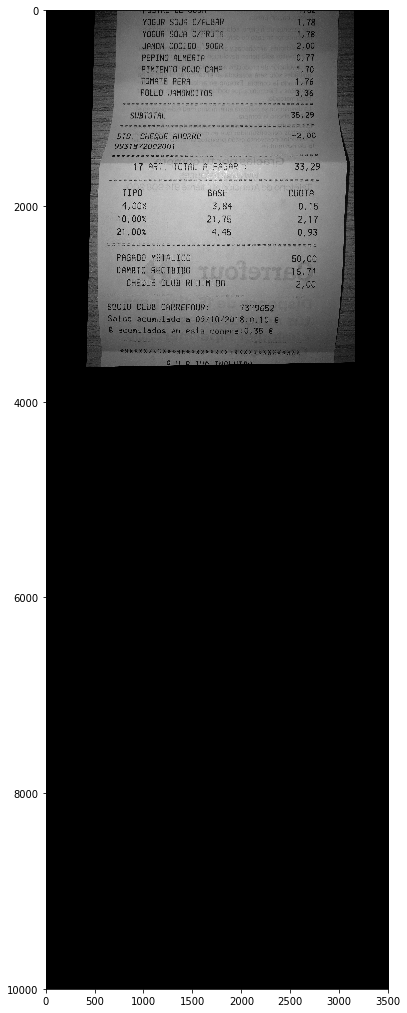

In [19]:
fig(18,18)

imshowg(t(H,x2))

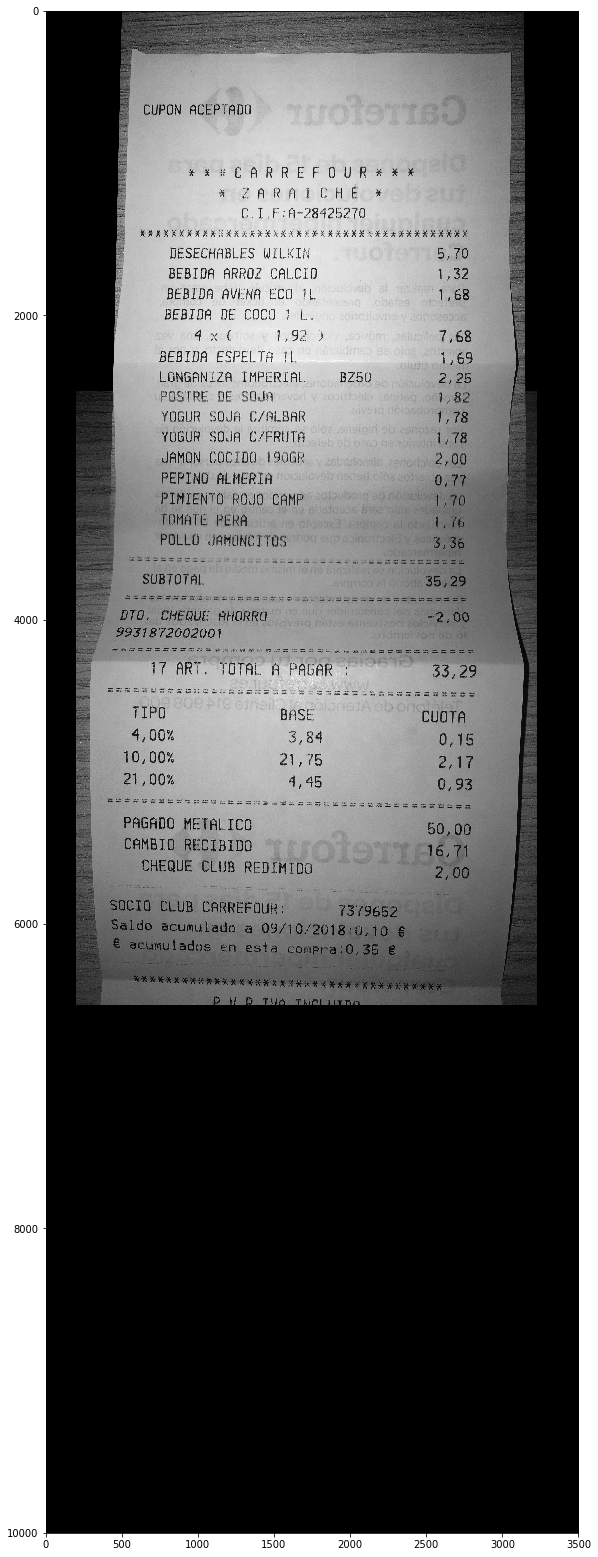

In [21]:
fig(28,28)

imshowg(np.maximum(t(np.eye(3),x2), t(H,x1)));